# ZOD Dataset Exploration - Camera-Specific Pedestrian Prediction



In [2]:
from pathlib import Path # for file path operations
import os # for file path operations
from PIL import Image # for image processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import json
import numpy as np
import pandas as pd
#import seaborn as sns
import torch
import torchvision
from collections import Counter
import cv2
import random
from collections import defaultdict



#### Establish paths to ZOD frames (original and ZOD256):

In [3]:
# This is the path to the ZOD256 dataset on the VM
# Its the ZOD dataset, cropped and resized it to 256x256. 
ZOD256_ROOT = Path("/mnt/pr_2018_scaleout_workdir/ZOD256/single_frames/")
# Path to original ZOD frames
ORIGINAL_ZOD_ROOT = Path("/home/edgelab/zod_dino_data/train2017/")
print("ZOD256_ROOT exists:", ZOD256_ROOT.exists())
print("ORIGINAL_ZOD_ROOT exists:", ORIGINAL_ZOD_ROOT.exists())




ZOD256_ROOT exists: True
ORIGINAL_ZOD_ROOT exists: True


## Dataset location and on-disk structure (local VM)

**Dataset root:** `/mnt/pr_2018_scaleout_workdir/ZOD256`

We will work with: 
- `single_frames` folder

### Frame folder structure, 100000 single frame directories:
`000000/`, ... , `099999/`

Each frame folder contains:
- `annotations/` — per-frame labels (e.g., 2D/3D boxes, segmentation, etc.)
- `camera_front_blur/` — anonymized camera image (blur)
- `camera_front_dnat/` — anonymized camera image (DNAT)
- `lidar_velodyne/` — LiDAR data for the keyframe

This exploration notebook focuses on **vision-only** using the front camera images
(`camera_front_blur` / `camera_front_dnat`) and the corresponding object labels
in `annotations/`, with emphasis on **pedestrians** and condition metadata.


### We will now compare the ZOD256 images with the original ones (images + annotations):

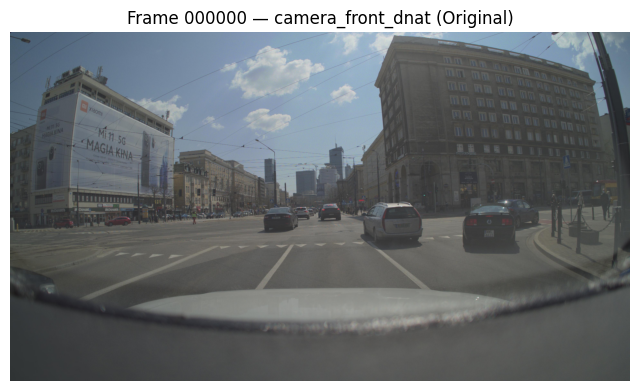

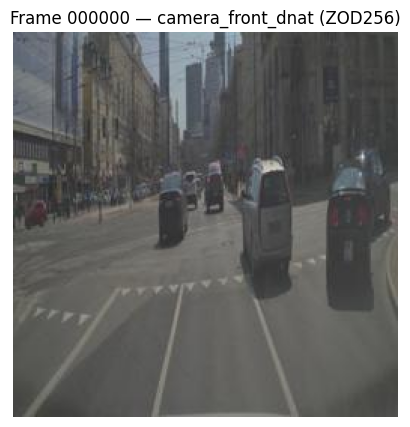

Original image size (W,H): (3848, 2168)
ZOD256 image size (W,H): (256, 256)


In [9]:
frame_id = "000000" # we look at the first frame in both datasets
# Now some visualization of the DNAT images in the two datasets:
ZOD256_first_frame_dir = ZOD256_ROOT / frame_id
ORIGINAL_first_frame_dir = ORIGINAL_ZOD_ROOT / frame_id
ZOD256_DNAT_DIR = ZOD256_first_frame_dir / "camera_front_dnat"
ORIGINAL_DNAT_DIR = ORIGINAL_first_frame_dir / "camera_front_dnat"

# Find the actual image files in these directories
zod256_dnat_files = list(ZOD256_DNAT_DIR.glob("*.jpg"))
original_dnat_files = list(ORIGINAL_DNAT_DIR.glob("*.jpg"))

# Check if files exist before trying to open them
if not zod256_dnat_files:
    raise FileNotFoundError(f"No .jpg files found in {ZOD256_DNAT_DIR}")
if not original_dnat_files:
    raise FileNotFoundError(f"No .jpg files found in {ORIGINAL_DNAT_DIR}")

# Read DNAT images (use the first file found)
ZOD256_DNAT_IMG = Image.open(zod256_dnat_files[0])
ORIGINAL_DNAT_IMG = Image.open(original_dnat_files[0])

# Display DNAT images
# Original DNAT image
plt.figure(figsize=(8, 5))
plt.imshow(ORIGINAL_DNAT_IMG)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_dnat (Original)")
plt.show()

# ZOD256 DNAT image
plt.figure(figsize=(8, 5))
plt.imshow(ZOD256_DNAT_IMG)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_dnat (ZOD256)")
plt.show()

# Image sizes pre/post resize:
print("Original image size (W,H):", ORIGINAL_DNAT_IMG.size)
print("ZOD256 image size (W,H):", ZOD256_DNAT_IMG.size)

*Challenges*: 
- **Image Quality and object sizes**: It is no surprise that image quality is significantly worse in the ZOD256 dataset and pedestrians much harder to identify with the blind eye. This could provide a significant challenge for pedestrian prediction. 
- **Cropped images**: If you look closely you can see that in addition to a resize, the images are cropped (only one red car on left-hand side in original image, one in cropped + resized image). This provides another challenge, as we must ensure that annotations (pedestrian metadata) are appropriately modified to account for this crop. Pedestrian counts per image will differ, for example. 

## Next we analyze frame-specific json files:

In [17]:

def read_json(path: Path):
    """
    Read a JSON file from disk and return it as a Python object.
    Parameters:
    - path: Path object pointing to a .json file
    Returns:
    - A Python dictionary or list (depending on the JSON content)
    """
    # first we open the file in read mode
    with open(path, "r") as file:

        # json.load reads JSON-formatted text from the file object 'file'
        # and converts it into native Python objects (dicts, lists, etc.)
        data = json.load(file)

    return data

# Read metadata describing environment conditions
ZOD256_first_frame_metadata = read_json(ZOD256_first_frame_dir / "metadata.json")
ORIGINAL_first_frame_metadata = read_json(ORIGINAL_first_frame_dir / "metadata.json")
#print(metadata)

# Read general info about the frame
ZOD256_first_frame_info = read_json(ZOD256_first_frame_dir / "info.json")
ORIGINAL_first_frame_info = read_json(ORIGINAL_first_frame_dir / "info.json")
#print(ZOD256_first_frame_info)
#print(ORIGINAL_first_frame_info)

print("metadata.json 000000 (keys: values)")
for k in ZOD256_first_frame_metadata.keys():
    print(f" - {k}: ZOD256={ZOD256_first_frame_metadata[k]}, ORIGINAL={ORIGINAL_first_frame_metadata[k]}")




metadata.json 000000 (keys: values)
 - frame_id: ZOD256=000000, ORIGINAL=000000
 - time: ZOD256=2021-04-19T10:23:10.444124Z, ORIGINAL=2021-04-19T10:23:10.444124Z
 - country_code: ZOD256=PL, ORIGINAL=PL
 - scraped_weather: ZOD256=partly-cloudy-day, ORIGINAL=partly-cloudy-day
 - collection_car: ZOD256=india, ORIGINAL=india
 - road_type: ZOD256=city, ORIGINAL=city
 - road_condition: ZOD256=normal, ORIGINAL=normal
 - time_of_day: ZOD256=day, ORIGINAL=day
 - num_lane_instances: ZOD256=21, ORIGINAL=21
 - num_vehicles: ZOD256=36, ORIGINAL=36
 - num_vulnerable_vehicles: ZOD256=5, ORIGINAL=5
 - num_pedestrians: ZOD256=40, ORIGINAL=40
 - num_traffic_lights: ZOD256=37, ORIGINAL=37
 - num_traffic_signs: ZOD256=35, ORIGINAL=35
 - longitude: ZOD256=20.993243252850032, ORIGINAL=20.993243252850032
 - latitude: ZOD256=52.24205173254378, ORIGINAL=52.24205173254378
 - solar_angle_elevation: ZOD256=49.17233721956617, ORIGINAL=49.17233721956617


#### We see that the metadata has not been adjusted at all despite the crop. 

- This is only problematic for fields with a count such as num_vehicles and num_pedestrians. That's okay for our purposes, since we will rely on *annotations/object_detection.json* for pedestrian counts instead. We will however check for consistency in count data across metadata.json / object_detection.json. 

- Note that info.json is a file with a bunch of file paths, which we will not use. 

### Annotations
Each annotation is referenced via a relative filepath under:
single_frames/000000/annotations/

- Object detection
- Lane markings
- Traffic signs
- Road condition


### LiDAR frames
- Sequence of Velodyne LiDAR scans at ~10 Hz
- Covers approximately ±1 second around the keyframe
- Stored as .npy point clouds
- All scans marked is_compensated: False


# object_detection.json

In [23]:
# Object detection annotations live inside the frame folder
ZOD256_obj_det_path = ZOD256_first_frame_dir / "annotations" / "object_detection.json"
ORIGINAL_obj_det_path = ORIGINAL_first_frame_dir / "annotations" / "object_detection.json"
print(ZOD256_obj_det_path.exists())
print(ORIGINAL_obj_det_path.exists())


# Reuse our existing helper (no need to re-write open/json.load every time)
# obj_det contents are lists of dictionaries, containing the annotations for each object in the frame.
ZOD256_obj_det = read_json(ZOD256_obj_det_path)
print(f"ZOD256_obj_det[0]: {ZOD256_obj_det[0]}")
ORIGINAL_obj_det = read_json(ORIGINAL_obj_det_path)
print(f"ORIGINAL_obj_det[0]: {ORIGINAL_obj_det[0]}")

# type and size of obj_det contents
print("Type of obj_det:", type(ZOD256_obj_det))
print("Number of objects in this frame:", len(ZOD256_obj_det))
print("Type of obj_det:", type(ORIGINAL_obj_det))
print("Number of objects in this frame:", len(ORIGINAL_obj_det))



True
True
ZOD256_obj_det[0]: {'geometry': {'coordinates': [[1664.73, 1033.14], [1665.88, 1034.75], [1663.35, 1122.14], [1661.97, 1121.91]], 'type': 'MultiPoint'}, 'properties': {'annotation_uuid': '0007dce0-769f-4775-92ef-23f9173daa7d', 'class': 'PoleObject', 'is_for_construction': False, 'is_on_dynamic_object': False, 'occlusion_ratio': 'Medium', 'traffic_content_visible': 'Undefined', 'type': 'LampPole', 'unclear': False}}
ORIGINAL_obj_det[0]: {'geometry': {'coordinates': [[1664.73, 1033.14], [1665.88, 1034.75], [1663.35, 1122.14], [1661.97, 1121.91]], 'type': 'MultiPoint'}, 'properties': {'annotation_uuid': '0007dce0-769f-4775-92ef-23f9173daa7d', 'class': 'PoleObject', 'is_for_construction': False, 'is_on_dynamic_object': False, 'occlusion_ratio': 'Medium', 'traffic_content_visible': 'Undefined', 'type': 'LampPole', 'unclear': False}}
Type of obj_det: <class 'list'>
Number of objects in this frame: 281
Type of obj_det: <class 'list'>
Number of objects in this frame: 281


We see above that the object detection annotations have not been adjusted post-crop and resize. THis is highly problematic and must be dealt with. The bounding boxis are in in the original scale even on the resized dataset. 

*NEXT* we check weather counts have been adjusted for ZOD256 crop. 

In [26]:
ZOD256_classes = []
ZOD256_missing_class_count = 0

ORIGINAL_classes = []
ORIGINAL_missing_class_count = 0

for obj in ZOD256_obj_det:
    props = obj.get("properties", {})  
    cls = props.get("class", None)
    
    if cls is None:
        missing_class_count += 1
    else:
        ZOD256_classes.append(cls)

for obj in ORIGINAL_obj_det:
    props = obj.get("properties", {})  
    cls = props.get("class", None)
    
    if cls is None:
        ORIGINAL_missing_class_count += 1
    else:
        ORIGINAL_classes.append(cls)

print(f"Total objects in ZOD256 frame: {len(ZOD256_obj_det)}")
print(f"Objects missing properties['class']: {ZOD256_missing_class_count}")
print(f"Total objects in ORIGINAL frame: {len(ORIGINAL_obj_det)}")
print(f"Objects missing properties['class']: {ORIGINAL_missing_class_count}")


ZOD256_class_counts = Counter(ZOD256_classes)

print("\nZOD256 Class counts (most common first):")
for cls, cnt in ZOD256_class_counts.most_common():
    print(f"{cls:25s}  {cnt}")

ORIGINAL_class_counts = Counter(ORIGINAL_classes)
print(f"\nORIGINAL Class counts (most common first):")
for cls, cnt in ORIGINAL_class_counts.most_common():
    print(f"{cls:25s}  {cnt}")

print(f"\nNumber of unique classes in this frame: {len(ZOD256_class_counts)}")


Total objects in ZOD256 frame: 281
Objects missing properties['class']: 0
Total objects in ORIGINAL frame: 281
Objects missing properties['class']: 0

ZOD256 Class counts (most common first):
Pedestrian                 57
TrafficGuide               52
PoleObject                 49
Vehicle                    46
TrafficSignal              37
TrafficSign                35
VulnerableVehicle          5

ORIGINAL Class counts (most common first):
Pedestrian                 57
TrafficGuide               52
PoleObject                 49
Vehicle                    46
TrafficSignal              37
TrafficSign                35
VulnerableVehicle          5

Number of unique classes in this frame: 7


Findings:
- ZOD256 object counts have not been adjusted to account for the crop, we will have to do that ourselves.
- Metadata.json pedestrian count is 40 which doesn't match the 57 that we see for this frame in annotations/object_detection.json. The reason for this is that there are 17 pedestrian objects in annotations marked as "unclear", essentially low-quality annotations. Metadata.json only includes those marked as "clear" in its count.  

In [31]:
# we now analyze the first object in the list:
# ZOD256_obj_det is a list of dictionaries, each containing a geometry and properties dictionary. 
ZOD256_first_obj = ZOD256_obj_det[0]

print(ZOD256_first_obj.keys())

geometry = ZOD256_first_obj["geometry"]
properties = ZOD256_first_obj["properties"]
print(f"geometry: {geometry}")
print(f"properties: {properties}")

dict_keys(['geometry', 'properties'])
geometry: {'coordinates': [[1664.73, 1033.14], [1665.88, 1034.75], [1663.35, 1122.14], [1661.97, 1121.91]], 'type': 'MultiPoint'}
properties: {'annotation_uuid': '0007dce0-769f-4775-92ef-23f9173daa7d', 'class': 'PoleObject', 'is_for_construction': False, 'is_on_dynamic_object': False, 'occlusion_ratio': 'Medium', 'traffic_content_visible': 'Undefined', 'type': 'LampPole', 'unclear': False}


## Coordinate scale mismatch (ZOD256)

- In `ZOD256`, the camera images are first cropped then resized to **256×256**.
- However, the 2D annotation coordinates in `annotations/object_detection.json` remain in the **original image coordinate system** (e.g., x/y values in the thousands).
- Therefore, to overlay boxes on the 256×256 images or to train a detector on ZOD256, we must **rescale coordinates on the fly**.

### On-the-fly coordinate rescaling

Let:
- `(W_old, H_old)` = original image width/height that the annotations refer to
- `(W_new, H_new) = (256, 256)`

Then for each annotation corner `(x, y)`:

- `x_scaled = x * (W_new / W_old)`
- `y_scaled = y * (H_new / H_old)`


In [11]:
frame_id = "000000"

# ZOD256 image filename
zod256_frame_dir = Path("/mnt/pr_2018_scaleout_workdir/ZOD256/single_frames") / frame_id
zod256_img = sorted((zod256_frame_dir / "camera_front_dnat").glob("*.jpg"))[0]
fname = zod256_img.name

print("ZOD256 filename:", fname)

# Try to find the same filename in the original dataset copy
orig_frame_dir = Path("/home/edgelab/zod_dino_data/train2017") / frame_id
orig_img_path = orig_frame_dir / "camera_front_dnat" / fname

print("Original image path:", orig_img_path)
print("Exists:", orig_img_path.exists())

if orig_img_path.exists():
    img = Image.open(orig_img_path)
    print("Original image size (W,H):", img.size)


ZOD256 filename: 000000_india_2021-04-19T10:23:10.444124Z.jpg
Original image path: /home/edgelab/zod_dino_data/train2017/000000/camera_front_dnat/000000_india_2021-04-19T10:23:10.444124Z.jpg
Exists: True
Original image size (W,H): (3848, 2168)


### We rescale and visualize bounding boxes to ensure these transformations are reasonable

In [12]:
#we convert the coordinates to a numpy array for easier manipulation
points_orig = np.array(geometry["coordinates"], dtype=np.float32)
print("Original points (x,y):", points_orig)

#original and resized image paths (frame 000000):
orig_img_path = "/home/edgelab/zod_dino_data/train2017/000000/camera_front_dnat/000000_india_2021-04-19T10:23:10.444124Z.jpg"
zod256_img_path = "/mnt/pr_2018_scaleout_workdir/ZOD256/single_frames/000000/camera_front_dnat/000000_india_2021-04-19T10:23:10.444124Z.jpg"
orig_img = Image.open(orig_img_path)
zod256_img = Image.open(zod256_img_path)
W_old, H_old = orig_img.size
W_new, H_new = zod256_img.size

print("Original image size (W,H):", W_old, H_old)
print("ZOD256 image size (W,H):", W_new, H_new)

sx = W_new / W_old
sy = H_new / H_old

print("Scale factors (sx, sy):", sx, sy)

# Copy to avoid modifying original data
points_scaled = points_orig.copy()

# x coordinates are in column 0
points_scaled[:, 0] *= sx
# y coordinates are in column 1
points_scaled[:, 1] *= sy

print("Scaled points (x,y):", points_scaled)



Original points (x,y): [[1015.39 1129.87]
 [1022.64 1146.49]
 [1017.27 1177.26]
 [1009.43 1133.06]]
Original image size (W,H): 3848 2168
ZOD256 image size (W,H): 256 256
Scale factors (sx, sy): 0.06652806652806653 0.11808118081180811
Scaled points (x,y): [[ 67.55193  133.41638 ]
 [ 68.03426  135.37889 ]
 [ 67.67701  139.01225 ]
 [ 67.155426 133.79308 ]]


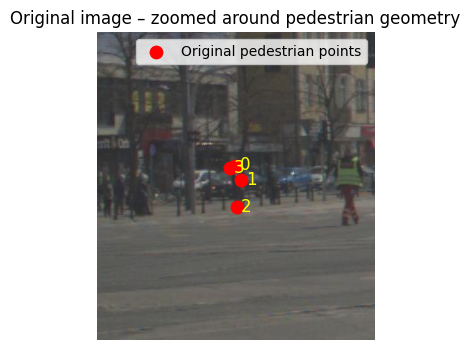

In [13]:
# ------------------------------------------------------------
# Zoom-in around original pedestrian points (original image)
# ------------------------------------------------------------


# Compute tight bounding box around the points
x_min, y_min = points_orig.min(axis=0)
x_max, y_max = points_orig.max(axis=0)

# Add padding so we see context (person + surroundings)
pad = 150  # pixels — feel free to increase/decrease

# Clamp to image boundaries
x0 = max(0, int(x_min - pad))
y0 = max(0, int(y_min - pad))
x1 = min(W_old - 1, int(x_max + pad))
y1 = min(H_old - 1, int(y_max + pad))

# ------------------------------------------------------------
# Plot zoomed original image
# ------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.imshow(orig_img)

# Overlay original points
ax.scatter(
    points_orig[:, 0],
    points_orig[:, 1],
    c="red",
    s=80,
    label="Original pedestrian points"
)

# Label each point (useful when points overlap)
for i, (x, y) in enumerate(points_orig):
    ax.text(x + 5, y + 5, str(i), fontsize=12, color="yellow")

# Zoom limits (note: y-axis inverted for images)
ax.set_xlim(x0, x1)
ax.set_ylim(y1, y0)

ax.set_title("Original image – zoomed around pedestrian geometry")
ax.axis("off")
ax.legend()

plt.show()


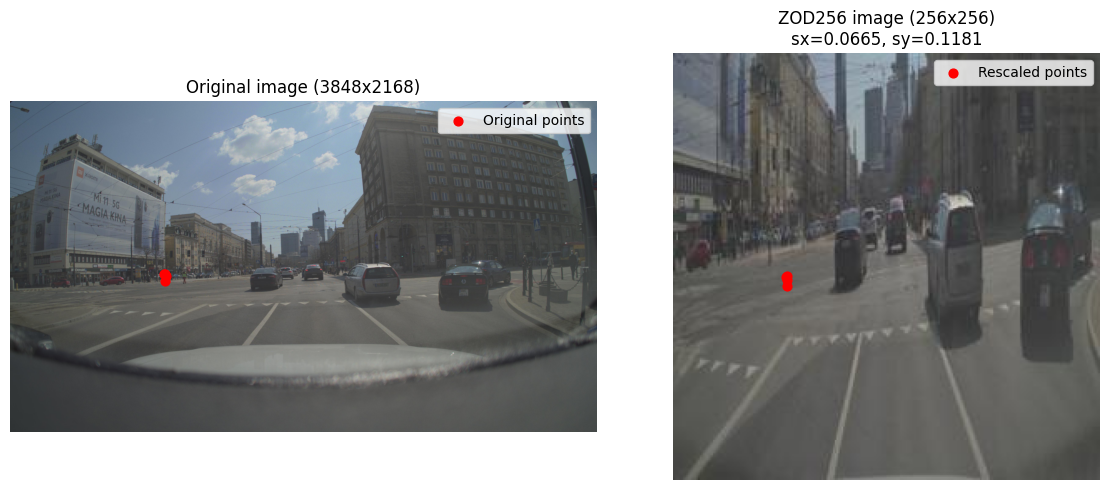

In [14]:
# ------------------------------------------------------------
# Visualization OF BOTH IMAGES 
# ------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- Original image ----
axes[0].imshow(orig_img)
axes[0].scatter(
    points_orig[:, 0],
    points_orig[:, 1],
    c="red",
    s=40,
    label="Original points",
)
axes[0].set_title(f"Original image ({W_old}x{H_old})")
axes[0].axis("off")
axes[0].legend()

# ---- ZOD256 image ----
axes[1].imshow(zod256_img)
axes[1].scatter(
    points_scaled[:, 0],
    points_scaled[:, 1],
    c="red",
    s=40,
    label="Rescaled points",
)
axes[1].set_title(
    f"ZOD256 image ({W_new}x{H_new})\n"
    f"sx={sx:.4f}, sy={sy:.4f}"
)
axes[1].axis("off")
axes[1].legend()

plt.tight_layout()
plt.show()


#### We see that the pedestrian boudning box looks reasonable in the original image, but completely off in the resized version. Perhaps there's some additional preprocessing other than pure rescaling. We can check this by rescalcing the original image and comparing with z256 version:

Mean absolute pixel difference (ZOD256 vs PIL-resize(original)): 28.51355489095052


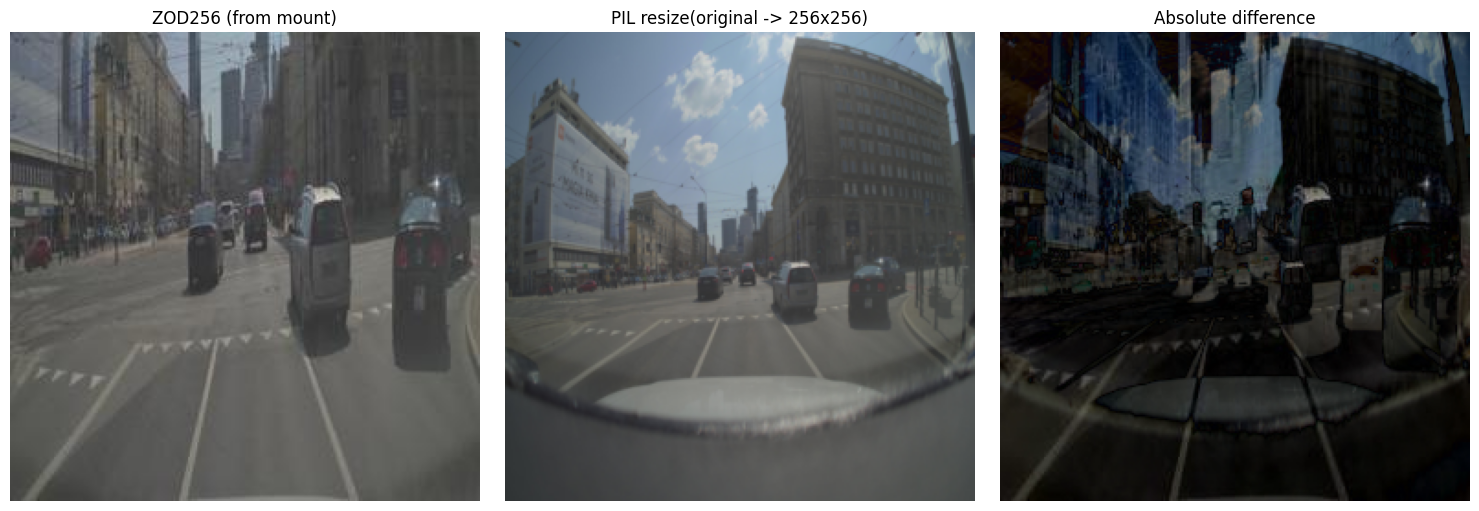

In [15]:

# Load original and ZOD256
orig = Image.open(orig_img_path).convert("RGB")
z256 = Image.open(zod256_img_path).convert("RGB")

# Create "our own ZOD256" by resizing the full original to 256x256
# (this matches the assumption behind sx=W_new/W_old and sy=H_new/H_old)
orig_resized = orig.resize((256, 256), resample=Image.BILINEAR)

# Convert to arrays for numeric comparison
A = np.asarray(z256).astype(np.int16)
B = np.asarray(orig_resized).astype(np.int16)

# Compute mean absolute pixel difference (0 means identical)
mad = np.mean(np.abs(A - B))
print("Mean absolute pixel difference (ZOD256 vs PIL-resize(original)):", mad)

# Visualize side-by-side + difference image
diff = np.abs(A - B).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(z256); axes[0].set_title("ZOD256 (from mount)"); axes[0].axis("off")
axes[1].imshow(orig_resized); axes[1].set_title("PIL resize(original -> 256x256)"); axes[1].axis("off")
axes[2].imshow(diff); axes[2].set_title("Absolute difference"); axes[2].axis("off")
plt.tight_layout()
plt.show()


We observe quite a large difference, indicating there's some other preperocessing at play. This means our current mapping is not the right transform for ZOD256. 

ECC correlation coefficient: 0.9820716810957656
Estimated affine warp matrix:
 [[7.3790801e-01 1.6754445e-04 3.3133663e+01]
 [1.4121797e-05 3.6794728e-01 9.4260803e+01]]


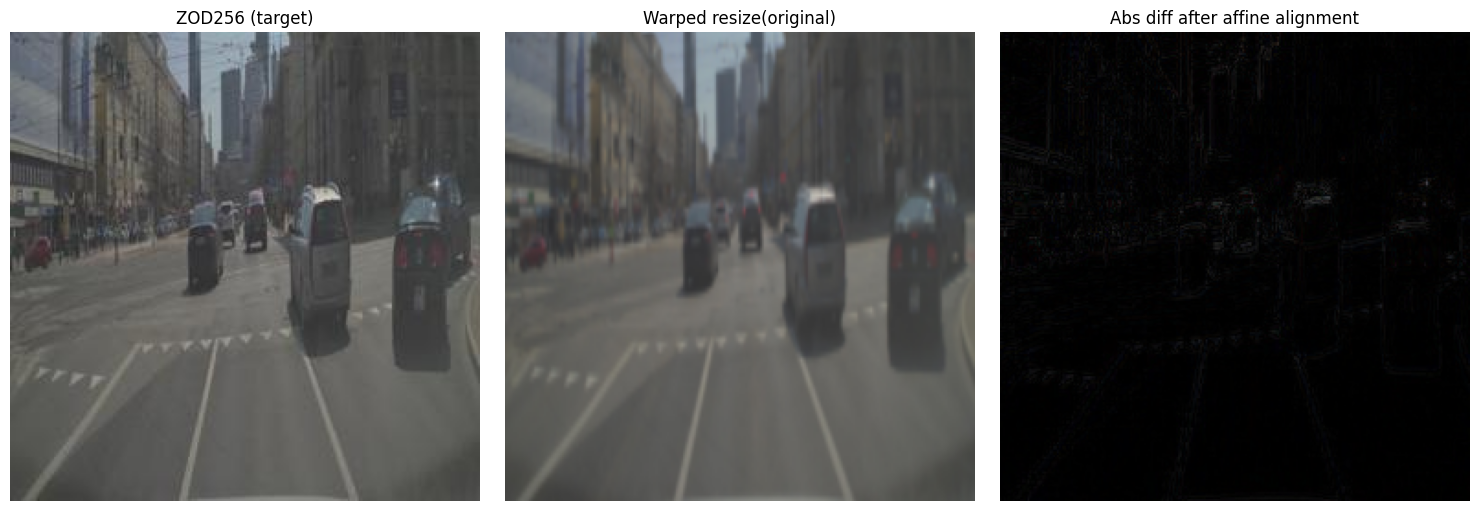

In [17]:
# Load images
orig = Image.open(orig_img_path).convert("RGB")
z256 = Image.open(zod256_img_path).convert("RGB")

# Make the "direct resize" candidate (256x256)
orig_resized = orig.resize((256, 256), resample=Image.BILINEAR)

# Convert to grayscale float32 in [0,1] (ECC expects float images)
I = np.asarray(orig_resized).astype(np.uint8)
J = np.asarray(z256).astype(np.uint8)

I_gray = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
J_gray = cv2.cvtColor(J, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

# ECC settings
warp_mode = cv2.MOTION_AFFINE         # affine: translation + rotation + scale + shear
warp_matrix = np.eye(2, 3, dtype=np.float32)

criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 200, 1e-6)

# Estimate warp that maps I_gray -> J_gray
cc, warp_matrix = cv2.findTransformECC(
    templateImage=J_gray,     # target
    inputImage=I_gray,        # source
    warpMatrix=warp_matrix,
    motionType=warp_mode,
    criteria=criteria,
    inputMask=None,
    gaussFiltSize=5
)

print("ECC correlation coefficient:", cc)
print("Estimated affine warp matrix:\n", warp_matrix)

# Apply warp to the resized original to see if it aligns with ZOD256
I_warp = cv2.warpAffine(I, warp_matrix, (256, 256), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

# Visualize: ZOD256, warped candidate, and absolute difference
diff = cv2.absdiff(np.asarray(z256), I_warp)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(z256); axes[0].set_title("ZOD256 (target)"); axes[0].axis("off")
axes[1].imshow(I_warp); axes[1].set_title("Warped resize(original)"); axes[1].axis("off")
axes[2].imshow(diff); axes[2].set_title("Abs diff after affine alignment"); axes[2].axis("off")
plt.tight_layout()
plt.show()


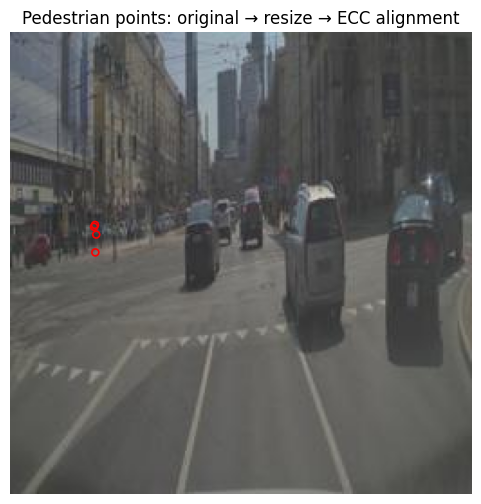

In [18]:
# points_orig: (N,2) in ORIGINAL image pixel coords (3848x2168)
# orig: PIL original image
# z256: PIL ZOD256 image
# warp_matrix: 2x3 from ECC

import numpy as np
import matplotlib.pyplot as plt

W_old, H_old = orig.size

# ------------------------------------------------------------
# Map original points -> "resized original" (256x256) coords
# ------------------------------------------------------------
sx = 256 / W_old
sy = 256 / H_old

points_resize = points_orig.copy().astype(np.float32)
points_resize[:, 0] *= sx
points_resize[:, 1] *= sy

# ------------------------------------------------------------
# Convert ECC affine 2x3 to full 3x3 homogeneous matrix
# ------------------------------------------------------------
M = np.eye(3, dtype=np.float32)
M[:2, :] = warp_matrix

# ------------------------------------------------------------
# Invert it (because image warp used WARP_INVERSE_MAP)
# ------------------------------------------------------------
M_inv = np.linalg.inv(M)

# ------------------------------------------------------------
# Apply inverse affine to points (homogeneous coords)
# ------------------------------------------------------------
ones = np.ones((points_resize.shape[0], 1), dtype=np.float32)
pts_h = np.concatenate([points_resize, ones], axis=1)   # (N,3)

points_aligned_h = (M_inv @ pts_h.T).T                  # (N,3)
points_aligned = points_aligned_h[:, :2]                # (N,2)

# ------------------------------------------------------------
# Plot on ZOD256 (small, unobtrusive markers)
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(z256)

# Small hollow circles so image content remains visible
ax.scatter(
    points_aligned[:, 0],
    points_aligned[:, 1],
    s=25,
    facecolors="none",
    edgecolors="red",
    linewidths=1.2
)


ax.set_title("Pedestrian points: original → resize → ECC alignment")
ax.axis("off")
plt.show()


ECC correlation coefficient: 0.9820716810957656
MAD baseline (direct_resize): 28.51355489095052
MAD aligned  (resize + ECC):  3.102605183919271


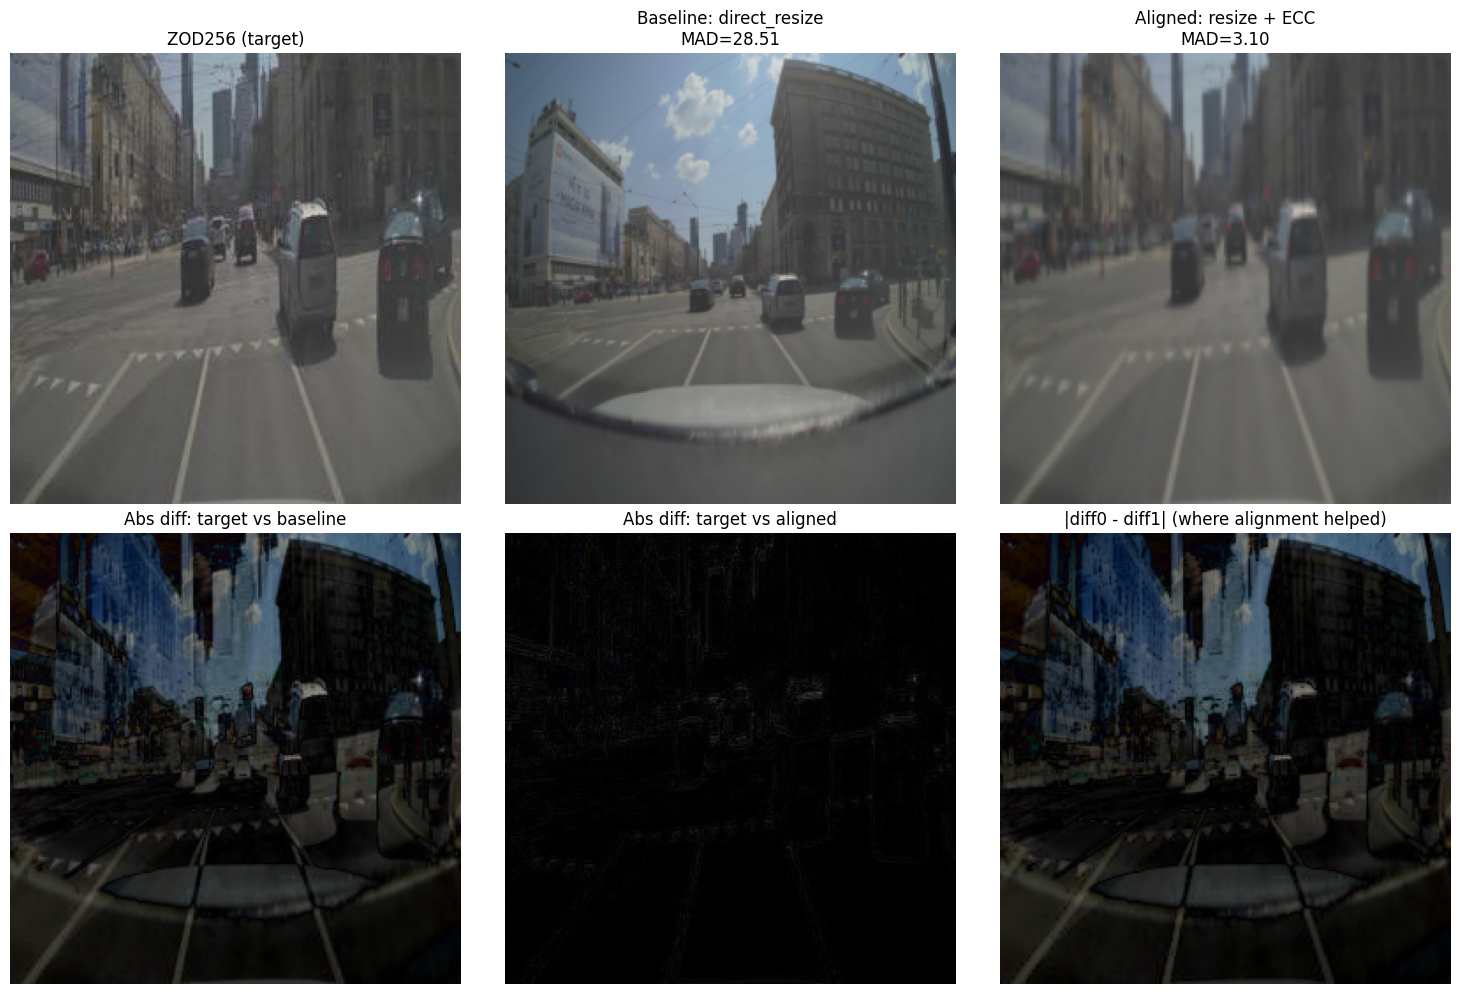

In [19]:
# Load images
orig = Image.open(orig_img_path).convert("RGB")
z256 = Image.open(zod256_img_path).convert("RGB")

# Baseline candidate: direct resize of original to 256x256
orig_resized = orig.resize((256, 256), resample=Image.BILINEAR)

# Convert to numpy
A = np.asarray(z256).astype(np.int16)          # target
B0 = np.asarray(orig_resized).astype(np.int16) # baseline

# ----------------------------
# Compute ECC warp (same as you already did)
# ----------------------------
I = np.asarray(orig_resized).astype(np.uint8)
J = np.asarray(z256).astype(np.uint8)

I_gray = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
J_gray = cv2.cvtColor(J, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

warp_matrix = np.eye(2, 3, dtype=np.float32)
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 200, 1e-6)

cc, warp_matrix = cv2.findTransformECC(
    templateImage=J_gray,
    inputImage=I_gray,
    warpMatrix=warp_matrix,
    motionType=cv2.MOTION_AFFINE,
    criteria=criteria,
    inputMask=None,
    gaussFiltSize=5
)

# IMPORTANT: to be consistent with what you did before, use WARP_INVERSE_MAP
I_warp = cv2.warpAffine(
    I,
    warp_matrix,
    (256, 256),
    flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
)

B1 = I_warp.astype(np.int16)  # aligned candidate

# ----------------------------
# Compute MADs
# ----------------------------
diff0 = np.abs(A - B0).astype(np.uint8)
diff1 = np.abs(A - B1).astype(np.uint8)

mad0 = float(np.mean(diff0))
mad1 = float(np.mean(diff1))

print("ECC correlation coefficient:", cc)
print("MAD baseline (direct_resize):", mad0)
print("MAD aligned  (resize + ECC): ", mad1)

# ----------------------------
# Visualize: target, baseline, aligned, and their diffs
# ----------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(z256)
axes[0, 0].set_title("ZOD256 (target)")
axes[0, 0].axis("off")

axes[0, 1].imshow(orig_resized)
axes[0, 1].set_title(f"Baseline: direct_resize\nMAD={mad0:.2f}")
axes[0, 1].axis("off")

axes[0, 2].imshow(I_warp)
axes[0, 2].set_title(f"Aligned: resize + ECC\nMAD={mad1:.2f}")
axes[0, 2].axis("off")

axes[1, 0].imshow(diff0)
axes[1, 0].set_title("Abs diff: target vs baseline")
axes[1, 0].axis("off")

axes[1, 1].imshow(diff1)
axes[1, 1].set_title("Abs diff: target vs aligned")
axes[1, 1].axis("off")

# Difference of differences (helps see improvement regions)
# Large values here mean ECC alignment changed pixel placement a lot (usually a good sign)
dod = np.abs(diff0.astype(np.int16) - diff1.astype(np.int16)).astype(np.uint8)
axes[1, 2].imshow(dod)
axes[1, 2].set_title("|diff0 - diff1| (where alignment helped)")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()


#### Given the added complexity here and unclear benefit to predicting multipoint bounding boxes for pedestrian prediction, I will stick to classifying pedestrian presence for now instead. 

## Counts per class:

In [20]:
# Each element in obj_det is one annotated object (dict with keys: "geometry", "properties")

classes_in_frame = set({obj["properties"]["class"] for obj in obj_det})

# initialize dict to count per class
count_per_class = {c: 0 for c in classes_in_frame}

for obj in obj_det:
    count_per_class[obj["properties"]["class"]] += 1

print(f"Number of unique classes in frame {frame_id}: {len(classes_in_frame)}")
for c, count in count_per_class.items():
    print(" -", c + ":", count)


print("Number of annotated objects in this frame:", len(obj_det))








Number of unique classes in frame 000000: 7
 - Pedestrian: 57
 - TrafficSignal: 37
 - TrafficGuide: 52
 - TrafficSign: 35
 - PoleObject: 49
 - VulnerableVehicle: 5
 - Vehicle: 46
Number of annotated objects in this frame: 281


We have a mismatch ---- in metadata we see num_pedestrians = 40, as opposed to 57 in annotations. 


In [21]:
# Helper: identify if an object is a pedestrian
def is_pedestrian(obj):
    return obj["properties"].get("class") == "Pedestrian"

# Pull all pedestrians in this frame
peds = [obj for obj in obj_det if is_pedestrian(obj)]
print("Pedestrians (raw from object_detection.json):", len(peds))

peds_not_unclear = [obj for obj in peds if not obj["properties"].get("unclear", False)]
print("Pedestrians with unclear == False:", len(peds_not_unclear))

# Occlusion ratio distribution (how many None/Medium/Heavy)
occ_counts = Counter([obj["properties"].get("occlusion_ratio") for obj in peds])
print("Pedestrian occlusion_ratio counts:", dict(occ_counts))


Pedestrians (raw from object_detection.json): 57
Pedestrians with unclear == False: 40
Pedestrian occlusion_ratio counts: {'VeryHeavy': 3, 'Light': 18, 'Heavy': 9, 'Medium': 5, None: 17, 'None': 5}


#### This means that metadata is only counting pedestrians with properties["unclear"] == False, wheras annotations coutns all pedestrians regardless of the "unclear" label. "unclear" means that the annotator isn’t confident / it’s ambiguous  ie low quality label.

- To maximize recall / robustness early, perhaps it's wise to include all pedestrians.

- Option A: Binary pedestrian presence likely too simple... Likely highly imbalanced (mostly 1s). Not very informative in dense urban scenes.
- Option B: Pedestrian count (regression or classification)
    - Much richer signal
    - Still avoids geometry headaches
- Option C: Thresholded presence (“crowdedness”)
    - ex: 0: none, 1: few (1–5), 2: many (6–15), 3: crowded (16+). 

- to make a decision here, we'd like some global statistics on pedestrian counts across all frames.

In [22]:
#Pedestrian counts per frame:
counts = []

# Get all frame directories (e.g. "000000", "000001", ...)
frame_dirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])

total_frames = len(frame_dirs)
print("Total number of frames:", total_frames)

for frame_dir in frame_dirs:
    ann_path = frame_dir / "annotations" / "object_detection.json"
    
    # Skip frames without annotations (safety)
    if not ann_path.exists():
        continue
    
    obj_det = read_json(ann_path)
    
    # Count pedestrians in this frame
    num_peds = sum(
        obj["properties"].get("class") == "Pedestrian"
        for obj in obj_det
    )
    
    counts.append(num_peds)

print("Frames processed:", len(counts))


Total number of frames: 100000
Frames processed: 100000


In [24]:
counts_np = np.array(counts)

print("Pedestrian count statistics:")
print("  Min:", counts_np.min())
print("  Max:", counts_np.max())
print("  Mean:", counts_np.mean())
print("  Median:", np.median(counts_np))

num_zero = np.sum(counts_np == 0)
print("Frames with ZERO pedestrians:", num_zero)
print("Fraction with ZERO pedestrians:", num_zero / len(counts_np))


Pedestrian count statistics:
  Min: 0
  Max: 137
  Mean: 3.59177
  Median: 1.0
Frames with ZERO pedestrians: 41013
Fraction with ZERO pedestrians: 0.41013


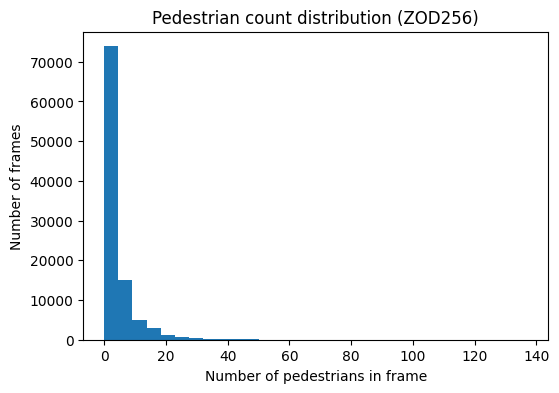

In [25]:
# Pedestrian count distribution:
plt.figure(figsize=(6, 4))
plt.hist(counts_np, bins=30)
plt.xlabel("Number of pedestrians in frame")
plt.ylabel("Number of frames")
plt.title("Pedestrian count distribution (ZOD256)")
plt.show()


In [26]:
def bin_count(n):
    if n == 0:
        return "0"
    elif n <= 5:
        return "1–5"
    elif n <= 15:
        return "6–15"
    else:
        return "16+"

binned = Counter(bin_count(n) for n in counts_np)
print("Binned pedestrian counts:")
for k, v in binned.items():
    print(f"  {k}: {v}")


Binned pedestrian counts:
  16+: 4525
  6–15: 17181
  1–5: 37281
  0: 41013


### Observations:
- Pedestrian presence is not trivial. 
    - ~41% of frames have zero pedestrians
    - ~59% have at least one pedestrian
    → well balanced for a presence task.
- There is a strong long tail:
    - Some frames have very large crowds (up to 100+)
    - Raw regression on counts would be noisy and unstable
- bins are surprisingly well balanced:
    - No bin dominates completely
    - Even 16+ has ~4.5% of data → enough to learn from

OVERALL ASSESSMENT
- Full 2D detection:
    - Requires geometry alignment
    - Heavy engineering
    - Not necessary for research question

- Raw pedestrian count regression:
    - Highly skewed
    - Sensitive to annotation noise
    - Harder to interpret
    → Possible, but not ideal

- Binary pedestrian presence: 
    - balanced, valid choice. 

- Binned pedestrian count (0 | 1–5 | 6–15 | 16+):
    - semantically meaningful (“none”, “few”, “many”, “crowded”)
    - robust to annotation noise
    - well balanced enough to train
    - Uses annotation density information
    - far richer than binary presence
    - Likely best choice. 

- 0 pedestrians → background-dominant scenes
- 1–5 → isolated interactions
- 6–15 → dense urban traffic
- 16+ → crowd scenes, occlusions, clutter


We frame pedestrian perception as a frame-level classification problem, predicting binned pedestrian counts (0, 1–5, 6–15, 16+).

In [ ]:
### CREATE BINNED PEDESTRIAN COUNT LABELS
label_per_frame = {}

for frame_dir in frame_dirs:
    frame_id = frame_dir.name  # e.g. "000000"
    obj_det = read_json(frame_dir / "annotations" / "object_detection.json")
    num_peds = sum(obj["properties"].get("class") == "Pedestrian" for obj in obj_det)
    label_per_frame[frame_id] = bin_count(num_peds)

# --> during training:
y = label_per_frame[frame_id]


## Weather conditions analysis:

In [ ]:
weather_values = []

# Get all frame IDs
frame_ids = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])

total_frames = len(frame_ids)

for fid in frame_ids:
    meta = read_json(DATA_ROOT / fid / "metadata.json")
    weather_values.append(meta.get("scraped_weather", None))

# Count weather occurrences
weather_counts = Counter(weather_values)

print(f"Total frames scanned: {total_frames}")
print("Weather distribution:")

for w, cnt in weather_counts.most_common():
    percentage = 100.0 * cnt / total_frames
    print(f" - {w}: {cnt} ({percentage:.2f}%)")


Total frames scanned: 100000
Weather distribution:
 - partly-cloudy-day: 29153 (29.15%)
 - cloudy: 18991 (18.99%)
 - clear-day: 16441 (16.44%)
 - rain: 15716 (15.72%)
 - partly-cloudy-night: 11124 (11.12%)
 - clear-night: 3999 (4.00%)
 - fog: 2117 (2.12%)
 - snow: 1972 (1.97%)
 - wind: 487 (0.49%)


### Pedestrian bounding-box size distribution
- measure of distribution of pedestrian distance across frames dataset

In [ ]:
# load object_detection.json for one frame (000000)
obj_det_path = first_frame_dir / "annotations" / "object_detection.json"
obj_det = read_json(obj_det_path)   # list of dicts

# find the first pedestrian object ---
ped_obj = None
for obj in obj_det:
    if obj["properties"].get("class") == "Pedestrian":
        ped_obj = obj
        break

print("Found pedestrian:", ped_obj is not None)

# extract the 4 bbox corner points
corners = ped_obj["geometry"]["coordinates"]
print("Corners (4 points):", corners)

# compute xmin/xmax/ymin/ymax ---
xs = [p[0] for p in corners]
ys = [p[1] for p in corners]

xmin, xmax = min(xs), max(xs)
ymin, ymax = min(ys), max(ys)

width  = xmax - xmin
height = ymax - ymin

print("xmin, ymin, xmax, ymax:", xmin, ymin, xmax, ymax)
print("width, height:", width, height)


Found pedestrian: True
Corners (4 points): [[1610.16, 1102.42], [1615.43, 1112.06], [1610.85, 1132.92], [1604.43, 1112.06]]
xmin, ymin, xmax, ymax: 1604.43 1102.42 1615.43 1132.92
width, height: 11.0 30.5


### Pedestrian occlusion distribution

In [ ]:
# Goal: compute a dataset-level "occlusion distribution" for Pedestrian objects
#
# We will scan ALL frames under DATA_ROOT, load each frame's object_detection.json,
# filter to objects with properties["class"] == "Pedestrian", then count how often
# each occlusion_ratio value occurs.
#
# Why do this?
# - It tells us how "hard" the pedestrian labels are (occluded pedestrians are harder).
# - It helps decide whether to include/exclude ambiguous ("unclear") annotations.



# ----------------------------
# Helper: identify pedestrians
# ----------------------------
def is_pedestrian(obj):
    """Return True if this annotation is a Pedestrian object."""
    return obj.get("properties", {}).get("class") == "Pedestrian"

# ----------------------------
# Scan frames and collect occlusion stats
# ----------------------------
occ_all = Counter()          # occlusion counts for ALL pedestrians (including unclear)
occ_clear = Counter()        # occlusion counts for pedestrians with unclear == False
missing_occ_all = 0          # count pedestrians with missing occlusion_ratio field
missing_occ_clear = 0

num_frames_seen = 0
num_frames_missing_ann = 0

num_peds_all = 0
num_peds_clear = 0

# List all frame directories (e.g., 000000, 000001, ...)
frame_dirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])
print("Total frame folders found:", len(frame_dirs))

for frame_dir in frame_dirs:
    ann_path = frame_dir / "annotations" / "object_detection.json"

    # If a frame doesn't have annotations, skip it (but keep count)
    if not ann_path.exists():
        num_frames_missing_ann += 1
        continue

    num_frames_seen += 1

    # Load annotation list (each element is one object dict)
    obj_det = read_json(ann_path)

    # Filter only pedestrian objects
    peds = [obj for obj in obj_det if is_pedestrian(obj)]

    for obj in peds:
        props = obj.get("properties", {})

        # ---- All pedestrians ----
        num_peds_all += 1
        occ = props.get("occlusion_ratio", None)
        if occ is None:
            missing_occ_all += 1
            occ_all["(missing)"] += 1
        else:
            occ_all[str(occ)] += 1  # cast to str so keys are consistent

        # ---- "Clear" pedestrians (unclear == False) ----
        # If unclear field is missing, .get(..., False) treats it as False
        # (i.e., we assume it's not unclear unless explicitly True)
        is_unclear = props.get("unclear", False)
        if not is_unclear:
            num_peds_clear += 1
            occ_c = props.get("occlusion_ratio", None)
            if occ_c is None:
                missing_occ_clear += 1
                occ_clear["(missing)"] += 1
            else:
                occ_clear[str(occ_c)] += 1

print("\nFrames processed (with annotations):", num_frames_seen)
print("Frames missing object_detection.json:", num_frames_missing_ann)

print("\nTotal pedestrian instances (all):", num_peds_all)
print("Total pedestrian instances (unclear==False):", num_peds_clear)

# ----------------------------
# print results (counts + percentages)
# ----------------------------
def print_counter_as_table(counter, total, title):
    print("\n" + title)
    print("-" * len(title))
    # Sort keys so output is stable/readable
    for k in sorted(counter.keys()):
        v = counter[k]
        pct = (v / total) * 100 if total > 0 else 0.0
        print(f"{k:12s}  {v:8d}  ({pct:6.2f}%)")

print_counter_as_table(
    occ_all,
    num_peds_all,
    title="Pedestrian occlusion_ratio distribution (ALL pedestrians)"
)

print_counter_as_table(
    occ_clear,
    num_peds_clear,
    title="Pedestrian occlusion_ratio distribution (ONLY unclear==False pedestrians)"
)

print("\nMissing occlusion_ratio (ALL):", missing_occ_all)
print("Missing occlusion_ratio (unclear==False):", missing_occ_clear)


Total frame folders found: 100000

Frames processed (with annotations): 100000
Frames missing object_detection.json: 0

Total pedestrian instances (all): 359177
Total pedestrian instances (unclear==False): 318582

Pedestrian occlusion_ratio distribution (ALL pedestrians)
---------------------------------------------------------
(missing)        40595  ( 11.30%)
Heavy            50690  ( 14.11%)
Light            93313  ( 25.98%)
Medium           53826  ( 14.99%)
None            100831  ( 28.07%)
VeryHeavy        19922  (  5.55%)

Pedestrian occlusion_ratio distribution (ONLY unclear==False pedestrians)
-------------------------------------------------------------------------
Heavy            50690  ( 15.91%)
Light            93313  ( 29.29%)
Medium           53826  ( 16.90%)
None            100831  ( 31.65%)
VeryHeavy        19922  (  6.25%)

Missing occlusion_ratio (ALL): 40595
Missing occlusion_ratio (unclear==False): 0


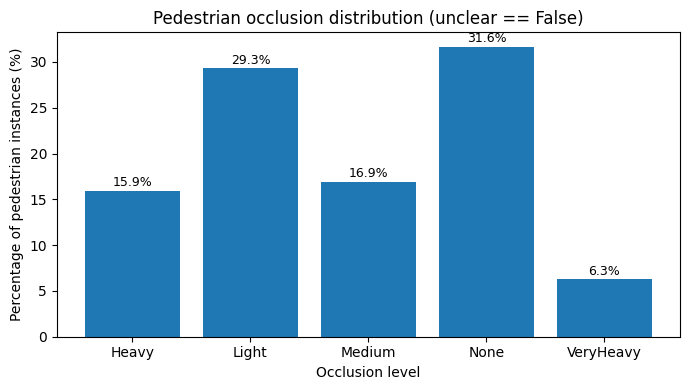

In [30]:
# Use the "clear" pedestrians only (unclear == False)
labels = []
counts = []

for k in sorted(occ_clear.keys()):
    labels.append(k)
    counts.append(occ_clear[k])

total = sum(counts)
percentages = [100 * c / total for c in counts]

plt.figure(figsize=(7, 4))
plt.bar(labels, percentages)
plt.ylabel("Percentage of pedestrian instances (%)")
plt.xlabel("Occlusion level")
plt.title("Pedestrian occlusion distribution (unclear == False)")

# Add percentage labels on top of bars
for i, pct in enumerate(percentages):
    plt.text(i, pct + 0.5, f"{pct:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


In [32]:
# Explicitly verify relationship between 'unclear' and 'occlusion_ratio'

num_unclear_peds = 0
num_unclear_with_occ = 0

for frame_dir in frame_dirs:
    ann_path = frame_dir / "annotations" / "object_detection.json"
    obj_det = read_json(ann_path)

    for obj in obj_det:
        props = obj.get("properties", {})
        if props.get("class") != "Pedestrian":
            continue

        if props.get("unclear", False):
            num_unclear_peds += 1
            if props.get("occlusion_ratio") is not None:
                num_unclear_with_occ += 1

print("Total unclear pedestrian instances:", num_unclear_peds)
print("Unclear pedestrians WITH occlusion label:", num_unclear_with_occ)


Total unclear pedestrian instances: 40595
Unclear pedestrians WITH occlusion label: 0


Each pedestrian instance in ZOD is annotated with a categorical occlusion level (None, Light, Medium, Heavy, VeryHeavy). Above we plot the dataset-level distribution of these occlusion levels for pedestrian annotations. 

In the ZOD256 split used in this work, all pedestrian annotations marked as unclear lack an occlusion label, whereas all clear pedestrian annotations include one. We therefore exclude annotations marked as unclear from the overall occlusion distribution.

- 89% of total pedestrian instances are marked unclear == False.
- Unclear pedestrians ≈ 11% of instances --> including unclear pedestrians is important for robustness. Excluding them would bias toward easy cases. 
- Every unclear pedestrian lacks an occlusion label
- Every clear pedestrian has an occlusion label


Across 100 000 frames, the dataset contains 359 177 pedestrian instances, with approximately 89% marked as clear annotations. Pedestrian occlusion is prevalent, with nearly 40% of pedestrian instances exhibiting medium-to-very heavy occlusion. Rather than filtering such cases, we treat occlusion as an inherent property of real-world urban perception. We frame pedestrian perception as a frame-level classification task, predicting binned pedestrian counts per frame.